In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad, create_organo
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference, set_init_point)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
nf, r_in, r_out = (20, 3, 5)
organo = create_organo(nf, r_in, r_out, seed=1553, rot=np.pi/12)

geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)

Reseting datasets values with new specs


      fun: 0.7322040099059477
 hess_inv: <80x80 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.96360282e-04, -1.00226182e-04, -5.66161377e-04,  2.28997499e-04,
       -2.99200471e-04, -1.46844172e-04, -2.45661077e-04,  6.69099931e-04,
        3.81798593e-05, -1.85436808e-04,  4.80382778e-05,  1.69138156e-04,
       -6.61048272e-05, -3.70486289e-04, -3.90640820e-04,  3.13805326e-05,
        2.91183576e-04,  6.14064953e-04,  7.76923159e-05,  2.53618315e-04,
        2.90452057e-04,  1.07523913e-04,  5.12913189e-04, -6.31469412e-05,
        4.90292392e-04, -2.17715162e-04, -7.73357573e-06,  1.16048098e-04,
        7.52435487e-05, -7.13534752e-04,  9.30197076e-05,  1.88071059e-04,
       -4.70536668e-05, -1.55372674e-04, -3.72482603e-05, -3.70899804e-04,
        7.29267954e-05,  2.52548926e-04, -4.12317168e-04, -3.27628963e-04,
       -2.80188275e-05, -4.84361627e-05, -6.62350538e-06, -3.62588840e-05,
       -6.75284142e-05, -2.16903004e-05, -5.43829090e-05,  7.70444774e-05,
 

In [3]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}

reg_weight = 1e-3
theta = 0.02

Force inference with tensions and pressions solved with NNLS

Solving time: 0.999555
Distance from th organo to exp organo : 12.262833958553273
Distance from th tensions to exp tensions : 0.385878902130499


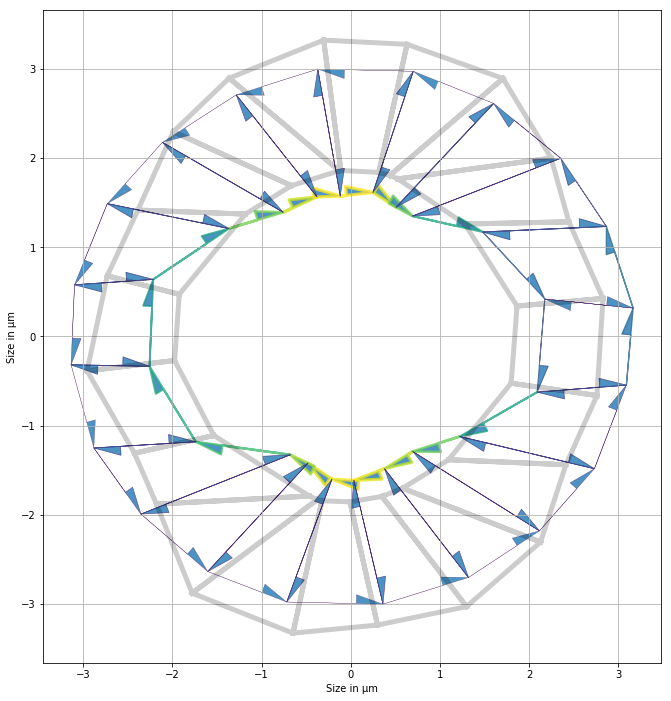

In [4]:
nb_cells = organo.Nf
initial_guess = infer_forces(organo, 'NNLS', sup_param='pressions')
start = time.clock()
pressions_organo = organo.copy()
pressions_organo.edge_df.line_tension = prepare_tensions(pressions_organo,
                                                            initial_guess['tensions'])
#print('Energy before optimization: ', model.compute_energy(pressions_organo, False))
Solver.find_energy_min(pressions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
#print('Energy after optimization: ', model.compute_energy(pressions_organo, False))
print_tensions(pressions_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, pressions_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] - initial_guess['tensions']))))

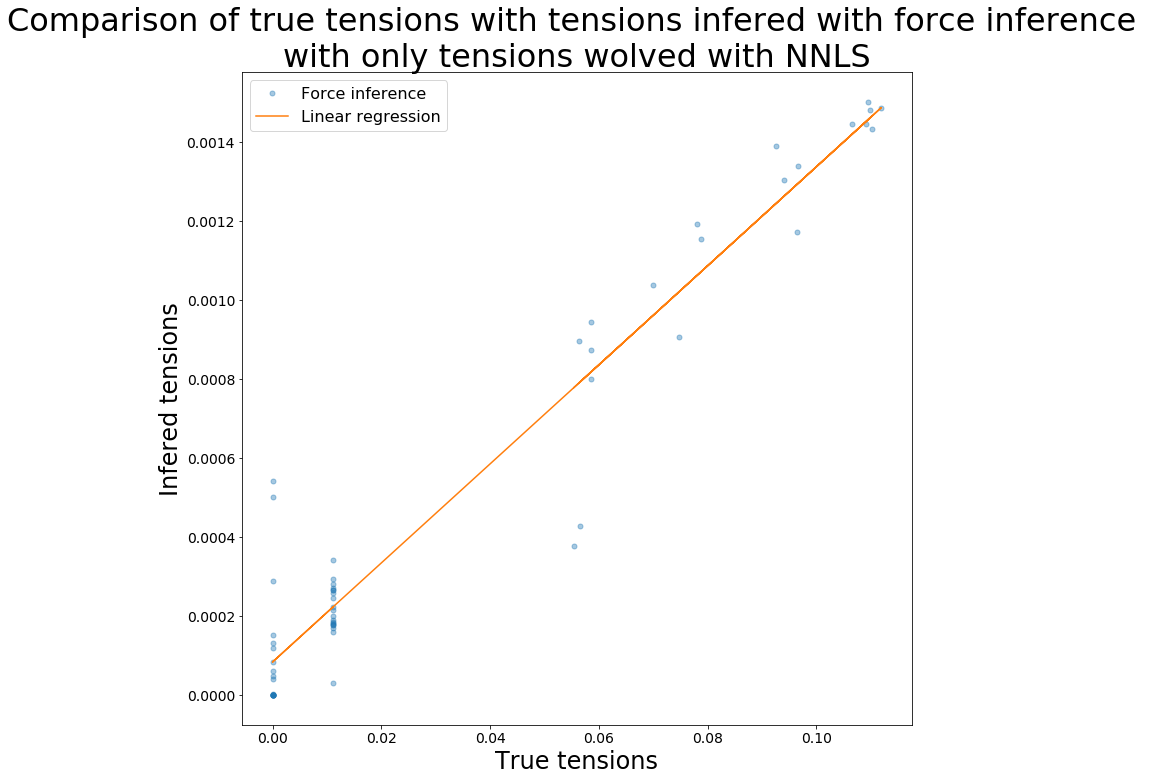

R value : 0.9670870560268384 
Standard error : 0.00011215413506417366


In [5]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  initial_guess['tensions'],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

Scale factor optimization

iter   time      nfev    incumbent   f(incumbent)
   1   13.94      10      9.00000     11.73823
   2   30.80      20      9.40000     11.26460
   3   48.79      31      9.45000     11.04847
   4   66.62      42      9.45500     11.04731
Brut force search summary
              solving time: 66.62282061576843
              nb iter: 4
              nfev: 42
              x_ub: 9.454999999999988
              ub: 11.047311283835478
Optimization terminated successfully.
         Current function value: 10.779892
         Iterations: 15
         Function evaluations: 33
Solving time: 124.490342


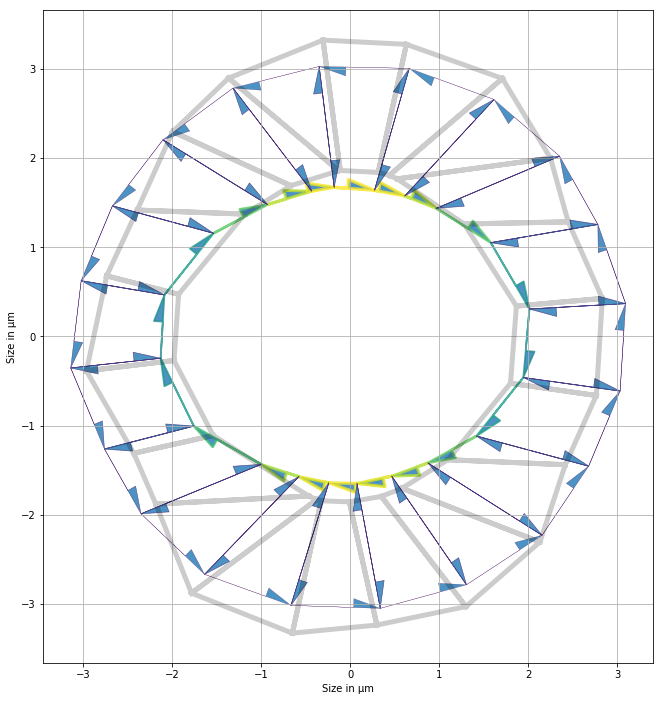

In [6]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='')
start = time.clock()
rescaled_pressions_organo = organo.copy()
opt_scale = adjust_scale(organo,
                         initial_guess['tensions'],
                         verbose=2,
                         **nm_opt)
rescaled_pressions_organo.edge_df.line_tension = prepare_tensions(rescaled_pressions_organo,
                                                                     opt_scale.x*initial_guess['tensions'])
Solver.find_energy_min(rescaled_pressions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(rescaled_pressions_organo, organo)

In [7]:
dist_init_point = np.sum(np.linalg.norm(_distance(pressions_organo, rescaled_pressions_organo), axis=1))
dist_optima = np.sum(np.linalg.norm(_distance(organo, rescaled_pressions_organo), axis=1))
tens_diff_init_point = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                             pressions_organo.edge_df.line_tension[:3*nb_cells]))
tens_diff_optima = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                         rescaled_pressions_organo.edge_df.line_tension[:3*nb_cells]))
print('Distance from th organo to exp organo at initial point : ' + str(dist_init_point))
print('Distance from th organo to exp organo at optima: ' + str(dist_optima))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_init_point))
print('Distance from th tensions to exp tensions at optima : ' + str(tens_diff_optima))

Distance from th organo to exp organo at initial point : 4.584149405887363
Distance from th organo to exp organo at optima: 10.77989150673876
Distance from th tensions to exp tensions at initial point : 0.385878902130499
Distance from th tensions to exp tensions at optima : 0.3370367694535988


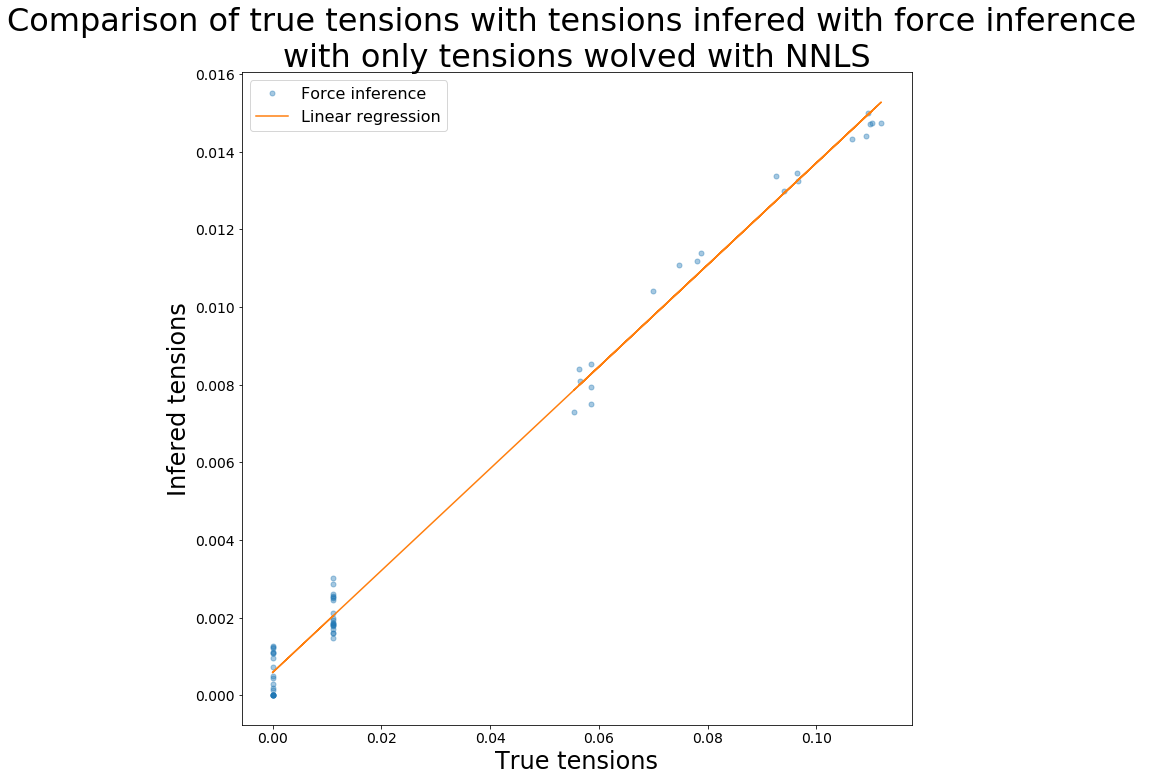

R value : 0.9960070152087337 
Standard error : 0.00040027809550913506


In [8]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  rescaled_pressions_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

Distance minimization

`xtol` termination condition is satisfied.
Function evaluations 315, initial cost 1.8244e+00, final cost 1.0097e+00, first-order optimality 3.79e+04.
Solving time: 881.6255060000001
Distance from th organo to exp organo : 10.789523395867953
Distance from th tensions to exp tensions : 0.3361681306039577


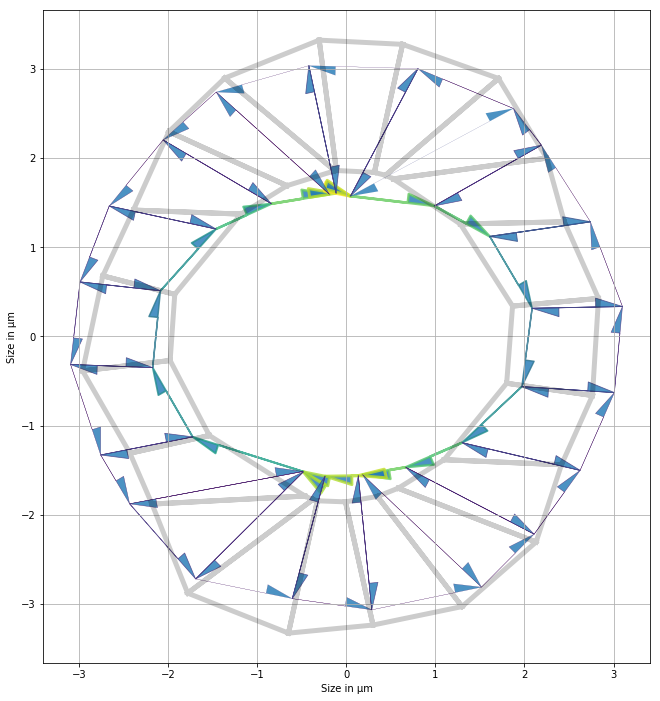

In [10]:
iprint_file = "../../assets/dist_at_each_f_ev/30_01_syn_pressions.txt"
res_sym_tensions = adjust_tensions(organo, opt_scale.x*initial_guess['tensions'], 
                                   {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                   energy_opt, iprint_file=iprint_file, **lm_opt)
opt_pressions_organo = organo.copy()
opt_pressions_organo.edge_df.line_tension = prepare_tensions(opt_pressions_organo, res_sym_tensions.x)
Solver.find_energy_min(opt_pressions_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_pressions_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, opt_pressions_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                opt_pressions_organo.edge_df.line_tension[:3*nb_cells]))))

In [15]:
dist_init_point = np.sum(np.linalg.norm(_distance(rescaled_pressions_organo, organo), axis=1))
dist_optima = np.sum(np.linalg.norm(_distance(organo, opt_pressions_organo), axis=1))
tens_diff_init_point = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                             rescaled_pressions_organo.edge_df.line_tension[:3*nb_cells]))
tens_diff_optima = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                         opt_pressions_organo.edge_df.line_tension[:3*nb_cells]))
print('Distance from th organo to exp organo at initial point : ' + str(dist_init_point))
print('Distance from th organo to exp organo at optima: ' + str(dist_optima))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_init_point))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_optima))

Distance from th organo to exp organo at initial point : 10.77989150673876
Distance from th organo to exp organo at optima: 10.789523395867953
Distance from th tensions to exp tensions at initial point : 0.3370367694535988
Distance from th tensions to exp tensions at initial point : 0.3361681306039577


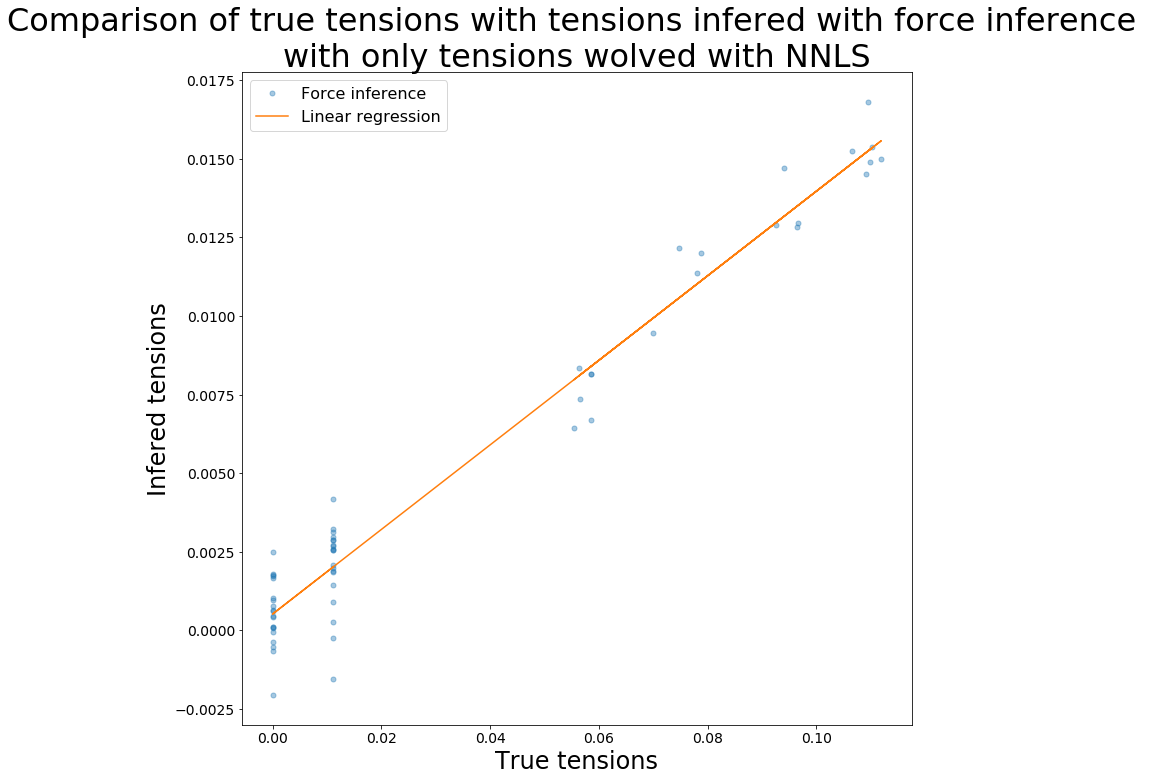

R value : 0.9792426809635595 
Standard error : 0.0009472037973704468


In [12]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  opt_pressions_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

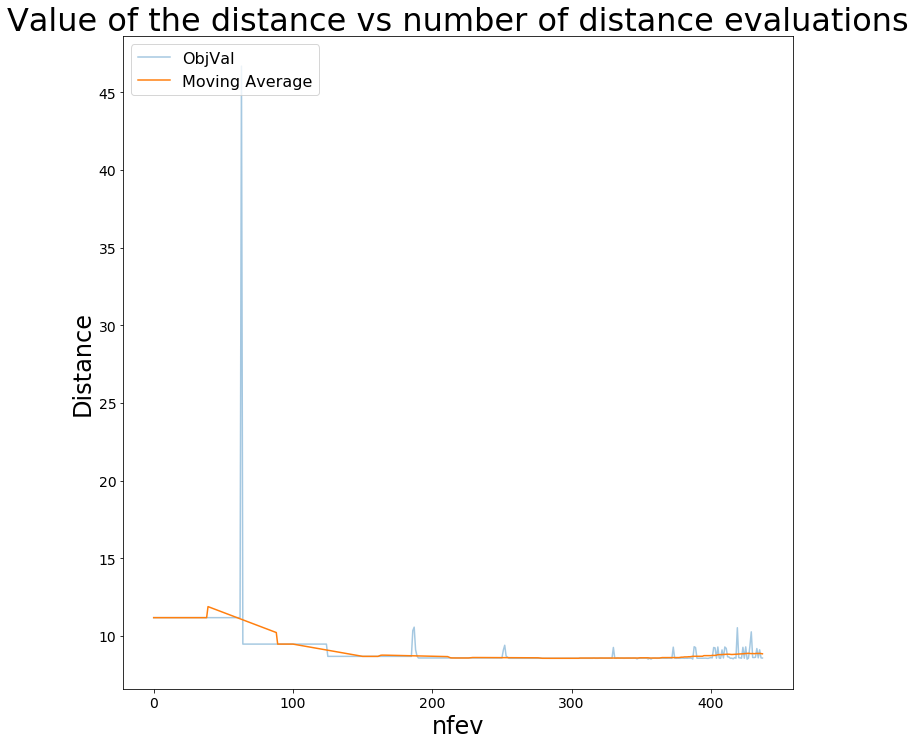

In [13]:
iter_data = pd.read_csv(iprint_file, header=None)
rendering_convergence_results(np.arange(len(iter_data[0])),
                              iter_data[0],
                              'Value of the distance vs number of distance evaluations',
                              'nfev', 'Distance', ('ObjVal', 'Moving Average'),
                              data_dot='-', rol_win=50)